In [1]:
import praw 
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

import utils

from nltk.tokenize import word_tokenize

In [2]:
with open("reddit_auth.json") as filename:
    auth = json.load(filename)

reddit = praw.Reddit(client_id=auth["client_id"],
                     client_secret=auth["client_secret"],
                     user_agent="stocks_test")

In [8]:
#Basic information about stocks
stocks = pd.read_csv("/Users/arnavprasad/Google Drive/Documents/Coding/Reddit stocks/NASDAQ_names.csv", index_col="Symbol")[["Name", "Last Sale", "Market Cap", "Country", "Sector"]]

stocks["Last Sale"].fillna("$0", inplace=True)

for i in stocks.index:
    stocks["Last Sale"][i] = float(stocks["Last Sale"][i][1:])

save_loc = "/Users/arnavprasad/Documents/GitHub/reddit-stocks/Figures"

In [5]:
title_conditions = ["Daily", "Nightly", "Post Market"]

posts = utils.get_posts(reddit, "thewallstreet", limit=20, title_conditions=title_conditions)

In [6]:
tickers = {}

for post in posts:
    for comment in post["comments"][:-1]:

        body = comment.body
        body_words = word_tokenize(body)

        for symbol in stocks.index:
            if symbol in body_words:

                if symbol in tickers.keys():
                    tickers[symbol]["comments"].append(body)
                    tickers[symbol]["num_comments"] += 1
                else:
                    tickers[symbol] = {"num_comments": 1, "comments": [body]}



In [7]:
symbols = []
num_comments = []

for k, v in tickers.items():

    if v["num_comments"] > 2:
        symbols.append(k)
        num_comments.append(v["num_comments"])

num_df = pd.DataFrame({"Symbol": symbols, "num_comments": num_comments})

num_df.sort_values("num_comments", ascending=False, inplace=True)


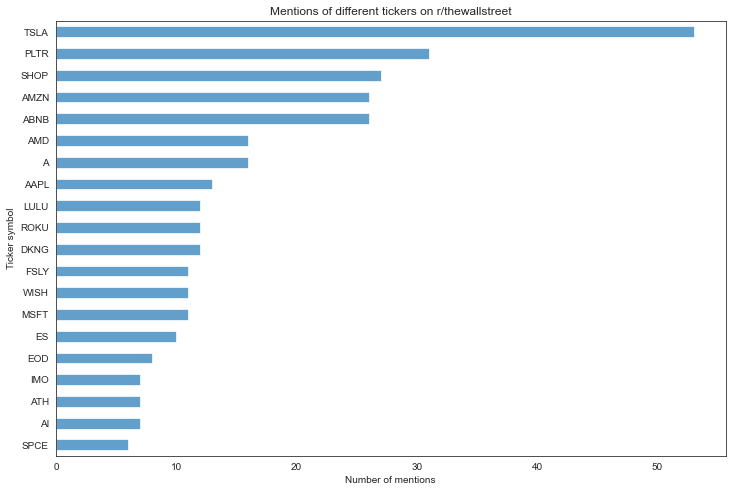

In [9]:
limit = 20

ax = num_df.iloc[:limit].plot.barh(x="Symbol", y="num_comments", alpha=0.7, legend=False, figsize=(12, 8))
ax.invert_yaxis()

plt.title("Mentions of different tickers on r/thewallstreet")

plt.ylabel("Ticker symbol")
plt.xlabel("Number of mentions")

plt.savefig(f"{save_loc}/mentions.jpg", dpi=300)